# 01 Exploration
 
Tests sur des exemples

In [5]:
import os

%cd "C:\Users\titou\OneDrive\Bureau\mva\xai\xaif"
print(os.getcwd())


C:\Users\titou\OneDrive\Bureau\mva\xai\xaif
C:\Users\titou\OneDrive\Bureau\mva\xai\xaif


491
chainsaw


RISE: 100%|██████████| 2000/2000 [04:23<00:00,  7.59it/s]


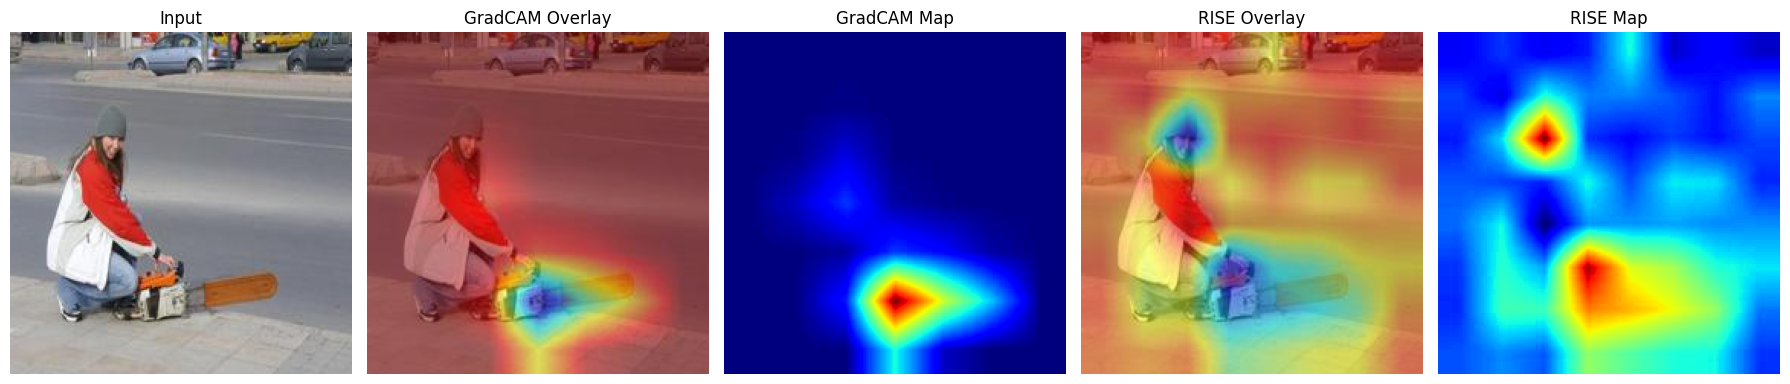

Image: C:\Users\titou\OneDrive\Bureau\mva\xai\xaif\data\imagenette2-320\val\n03000684\n03000684_851.JPEG
Synset: n03000684
Label: chainsaw
ImageNet index: 3
Results saved in: C:\Users\titou\OneDrive\Bureau\mva\xai\xaif\outputs\chainsaw_1500


In [ ]:
from pathlib import Path
import json
from PIL import Image
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

from xaif.scripts.tools_for_data.data import image_to_tensor, load_image
from xaif.scripts.models.gradcam import compute_gradcam
from xaif.scripts.models.rise import compute_rise_saliency
from xaif.scripts.models.reset import get_resnet50, predict_class
from xaif.scripts.tools_for_data.visualize import save_overlay_from_pil


# -------------------------------------------------
# Project paths
# -------------------------------------------------

project_root = Path.cwd().resolve()
if project_root.name == "notebooks":
    project_root = project_root.parent

data_root = project_root / "data" / "imagenette2-320" / "val"
labels_path = project_root / "data" / "imagenet_labels.json"


# -------------------------------------------------
# Load dataset + sample image
# -------------------------------------------------

dataset = ImageFolder(str(data_root))

sample_index = 1500  # <-- change this index

image_path, class_idx = dataset.samples[sample_index]
image_path = Path(image_path)

synset = image_path.parent.name  # ex: n03394916


# -------------------------------------------------
# Load ImageNet labels
# -------------------------------------------------

with open(labels_path, "r", encoding="utf-8") as f:
    imagenet_labels = json.load(f)


# -------------------------------------------------
# Model + prediction
# -------------------------------------------------

device = "cpu"  # or "cuda"

model, _ = get_resnet50(device=device)

input_tensor = image_to_tensor(
    image_path,
    image_size=224,
    device=device
)



pred_class = predict_class(model, input_tensor)
print(pred_class)
label = imagenet_labels[pred_class]
print(label)

# -------------------------------------------------
# Output directory
# -------------------------------------------------

safe_label = label.replace(" ", "_")
out_dir = project_root / "outputs" / f"{safe_label}_{sample_index:04d}"
out_dir.mkdir(parents=True, exist_ok=True)



# -------------------------------------------------
# Grad-CAM
# -------------------------------------------------

cam = compute_gradcam(
    model,
    input_tensor,
    target_layers=[model.layer4[-1]],
    target_class=pred_class
)



# -------------------------------------------------
# RISE saliency
# -------------------------------------------------




rise_map = compute_rise_saliency(
    model=model,
    input_tensor=input_tensor,
    pred_class=pred_class,
    N=2000,
    s=8,
    p1=0.5
)



# -------------------------------------------------
# Save visualizations
# -------------------------------------------------

img = load_image(image_path)

# Input
img.resize((224, 224)).save(out_dir / "input.jpg")

# Grad-CAM
save_overlay_from_pil(img, cam, out_dir / "gradcam_overlay.jpg")
Image.fromarray((cam * 255).astype("uint8")).save(
    out_dir / "gradcam_map.jpg"
)

# RISE
save_overlay_from_pil(img, rise_map, out_dir / "rise_overlay.jpg")
Image.fromarray((rise_map * 255).astype("uint8")).save(
    out_dir / "rise_map.jpg"
)


# -------------------------------------------------
# Display results
# -------------------------------------------------

fig, axes = plt.subplots(1, 5, figsize=(18, 4))

axes[0].imshow(Image.open(out_dir / "input.jpg"))
axes[0].set_title("Input")
axes[0].axis("off")

axes[1].imshow(Image.open(out_dir / "gradcam_overlay.jpg"))
axes[1].set_title("GradCAM Overlay")
axes[1].axis("off")

axes[2].imshow(Image.open(out_dir / "gradcam_map.jpg"), cmap="jet")
axes[2].set_title("GradCAM Map")
axes[2].axis("off")

axes[3].imshow(Image.open(out_dir / "rise_overlay.jpg"))
axes[3].set_title("RISE Overlay")
axes[3].axis("off")

axes[4].imshow(Image.open(out_dir / "rise_map.jpg"), cmap="jet")
axes[4].set_title("RISE Map")
axes[4].axis("off")

plt.tight_layout()
plt.show()


# -------------------------------------------------
# Logs
# -------------------------------------------------

print(f"Image: {image_path}")
print(f"Synset: {synset}")
print(f"Label: {label}")
print(f"ImageNet index: {pred_class}")
print(f"Results saved in: {out_dir}")
